
今回は単純パーセプトロンについてpython3.7(jupyter notebook)を用いて実装、確認していきます。

In [1]:
"""
今回使うモジュール
"""
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 単純パーセプトロン...とは？
***
単純パーセプトロンとは $D$ 個の入力に対し、各入力をそれぞれ重み付け、足し合わせた値がある閾値を超えたかどうかを判別し、超えていたら1を、そうでないなら0を返すニューラルネットワークを考える上で用いられる最も簡単なモデルの一つです。このモデルに対し、適切な重みと閾値を設定することによって入力データを２つのクラスに分類することができます。

<img src="figs/perceptron.png" width="500">

この動作はちょうど、受け取った信号がある閾値を超えると発火し、また次の層へ信号を発するニューロンの仕組みに対応しています。

ここで$n$次元のベクトルで表される入力を ${\bf x} (x_1, x_2, ... , x_D)$ 

入力に対する重みを ${\bf w}(w_1, w_2, ... , w_D)$

閾値を$\theta$

出力$\{0, 1\}$を$y$    とすると上記の文章は次の式に変形することができます。

$$
y=
  \begin{cases}
     1\quad(w_1x_1+w_2x_2+\cdots+w_D x_D\geq\theta)\\
     0\quad(w_1x_1+w_2x_2+\cdots+w_D x_D<\theta)
  \end{cases}
$$
また  $$
f(x)=
  \begin{cases}
     1\quad(x\geq0)\\
     0\quad(x<1)
  \end{cases}
$$
で定義される関数$f(x)$を用いることで
$$
y=f(w_1x_1+w_2x_2+\cdots+w_D x_D-\theta)
$$

と表すことができます。この$f(x)$のことを **ステップ関数** と呼びます。

さらに表記を簡略化するためにベクトル表記すれば
$$
y=f({\bf w}^T {\bf x}-\theta)
$$
となります。

# 重みをどうやって決めるの？
***

これからは分類の話に移ります。入力ベクトルとそのベクトルがどちらのクラスであるかの組の集合である教師データを学習し
未知の入力が来たときにそれがどちらのクラスに属するのかを判別することがこの分類機に求められる動作ですが
ここでは2つのクラスに属する全てのデータ点がそれぞれ完全に線形関数で分離することが可能なデータについて考えます。

現在の重みを用いて判別した結果、誤識別してしまう量を**誤差関数**といいそれを最小化するするように重みを更新していく方法が一般的(なのですが今回はステップ関数によって誤差の量が0, 1に圧縮されてしまい、勾配を求めることができないので、誤識別してしまったデータ${\bf x}_i$に対し${\bf w}^T{\bf x}_i - \theta$を用いて勾配計算を行うことにします。${\bf w}^T{\bf x}_i - \theta$は${\bf w}$で表される決定面からの距離を表すので、この値が大きいほど大きく重みを変化させる必要があります。

すると次のアルゴリズムを使用することでデータを完全に分離できる重みベクトル  ${\bf w}$  を求めることができます。

入力  ${\bf x}_i$  に対して、モデルが出力するクラスを  $t_i$ 、実際のクラスを  $y_i$  と表します。

初期値 <br>$i=0$<br>$w_j(j=1, 2, ... , D)$は分散1平均0の正規分布からそれぞれ抽出<br>${\theta}=0$

- 全ての予測と実際のクラスが合致するまで次を繰り返す<br>
    - ある　i　に対して$t_i\neq y_i$なら次を実行し${\bf w}$を更新<br>
        - ${\bf w} = {\bf w}-(y-t){\bf x}$
        - $b = b - (y-t)$
        
このアルゴリズムのことを誤り訂正学習方と呼びます。誤り訂正学習法では出力が大きすぎるときには重みと入力の積を小さく閾値を大きくし、逆の場合は重みと入力の積を大きく閾値を小さくしていくことで完全に要素を分離できる決定面を探します。ただし仮定として互いのクラスが特徴量の線形結合で表される決定面で完全に分離可能でなくてはなりません。
<br>
<br>
仮定として互いのクラスが特徴量の線形結合で表される決定面で完全に分離可能でなくてはなりません。と最後に書きましたがこれは実はとても重大な欠点となります。なぜなら、データ集合が決定面で完全に分離可能なのかまたはそうでないのかというのは収束するまで判別することができないからです。例えば二次元の入力に対して１つの出力を行う単純な論理回路の一つにxor回路がありますが、この方法では判別することができません。これらの問題に対しては**多層パーセプトロン**などの手法が考案されています。
<br>

In [2]:
class SimplePerceptron(object):
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.w = np.random.normal(size=(input_dim, ))
        self.b = 0
    
    def forward(self, x):
        y = self.step(np.matmul(self.w.T, x) + self.b)
        return y
    
    def compute_deltas(self, x, t):
        y = self.forward(x)
        delta = y-t
        dw = delta*x
        db = delta
        return dw, db
    
    def compute_loss(self, dw, db):
        return all(dw == 0)*(db == 0)
    
    def train_step(self, x, t):
        dw, db = self.compute_deltas(x, t)
        loss = self.compute_loss(dw, db)
        self.w = self.w - dw
        self.b = self.b - db
        return loss
    
    def search(self, x, t):
        while True:
            classified = True
            for i in range(len(x)):
                loss = self.train_step(x[i], t[i])
                classified *= loss
            if classified:
                break
                
    def step(self, x):
        return 1 * (x>0)

```python
class SimplePerceptron(object):
```
- 単純パーセプトロンを行うためのクラス
***
```python
    def __init__(self, input_dim):
```
- インスタンス生成時の初期値を決定する。
- 何回やっても極所解に到達してしまうという事態を避けるために${\bf w}$の各要素((input_dim)個）は正規分布に従いランダムになるようにしておく
***
```python
    def forward(self, x):
```
- ある入力に対する予想クラスを返す関数
***
```python
    def compute_deltas(self, x, t):
```
- 学習データに対して現在の予測クラスと正解クラスが合っているかを確認し、その誤差を返す関数
***
```python
    def compute_loss(dw, db):
```
- 各データに対してパラメータの更新をする必要が有るかどうかを返す関数
***
```python
    def train_step(self, x, t):
```
- 各データに対してパラメータの更新を実際に行う関数
***
```python
    def search(self, x, t):
```
- 与えられる全データに対して正しく分類できるようなパラメータを探索する関数

In [15]:
np.random.seed(123) #乱数シード
'''
1.データの準備
'''
d = 2 #データの次元
N = 200 #データ数
mean = 5

x1 = np.random.randn(N//2, d)+np.array([0, 0])
x2 = np.random.randn(N//2, d)+np.array([mean, mean])

t1 = np.zeros(N//2)
t2 = np.ones(N//2)

x = np.concatenate((x1, x2), axis=0) #入力データ
t = np.concatenate((t1, t2))                #出力データ

In [16]:
'''
2.モデルの構築
'''
model = SimplePerceptron(input_dim=d)

In [17]:
'''
3.モデルの学習
'''
model.search(x, t)

w:  [1.81235087 2.55800004]
b :  -12.0
(0, 0) ->  0
(5, 5) ->  1


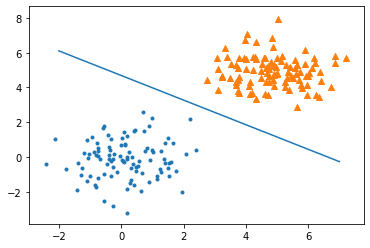

In [18]:
'''
4.モデルの評価
'''
print('w: ', model.w)
print('b : ', model.b)
print('(0, 0) -> ', model.forward([0, 0]))
print('(5, 5) -> ', model.forward([5, 5]))
x1_ =np.linspace(-2, 7, 90)
x2_ = (-model.b-model.w[0]*x1_) / model.w[1]
plt.plot(x1_, x2_)
plt.scatter(x1[:, 0],x1[:, 1],marker='.')
plt.scatter(x2[:, 0],x2[:, 1],marker='^')
plt.show()